In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

In [71]:
# # Visualize kernel
# from modelval.kernel import KernelGen
# plt.figure(figsize=(5,3))
# ker_test = KernelGen()
# ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=5, scale=0.1, shift=-1)
# ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=7, scale=0.15)
# ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=10, scale=0.5, shift=-1)
# plt.plot(ker_test.kernel_pre, label='ker_pre')
# plt.plot(ker_test.kernel_post, label='ker_post')
# plt.plot(ker_test.kernel_post_post, label='ker_post_post')
# plt.legend()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


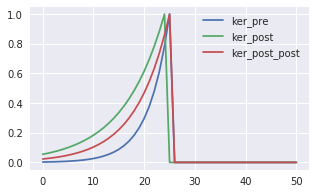

In [85]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms
tau_post_post = tau[3]/reso_set # ms

ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=tau_pre_post, scale=1, shift=-1)
ker_test.kernel_pre = ker_test.kernel_pre/np.linalg.norm(ker_test.kernel_pre)
ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=tau_post_pre, scale=1)
ker_test.kernel_post = ker_test.kernel_post/np.linalg.norm(ker_test.kernel_post)
ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=tau_post_post, scale=1, shift=-1)
ker_test.kernel_post_post = ker_test.kernel_post/np.linalg.norm(ker_test.kernel_post)
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()

In [86]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [87]:
# Generate data
ptl_list = [1,2,3,4]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data[data['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

# Insert values for Quadruplet protocol
for i in range(len(dt)):
    if np.abs(dt[i])>10:
        new_try2 = data[data['ptl_idx']==3].iloc[0]
        new_try2['dt2'] = dt[i]
        data_select = data_select.append(new_try2, ignore_index=True)
        
kernel_scale = np.array([a[0], a[2], a[3]/a[0]])

spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data_select, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, kernel_scale=kernel_scale, aug_times=[10,10,10,10], net_type='triplet')

In [88]:
kernel_scale

array([ 0.0061    ,  0.0016    ,  1.09836066])

In [89]:
targets.shape

(3320, 1)

In [90]:
spk_pairs.shape

(3320, 30000, 2)

In [91]:
# Create the network
ground_truth_init = 0
reg_scale = (0,0)
toy_data_net2 = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, kernel_scale=kernel_scale, reg_scale=reg_scale, n_input=spk_pairs.shape[1])

In [92]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/TripNet_ptl1-4_toy'
toy_net2_trainer = trainer.Trainer(toy_data_net2.mse,toy_data_net2.loss, input_name=toy_data_net2.inputs, target_name=toy_data_net2.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net2.lr})

In [93]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

array([-0.22614121, -0.27994752,  0.95375919], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


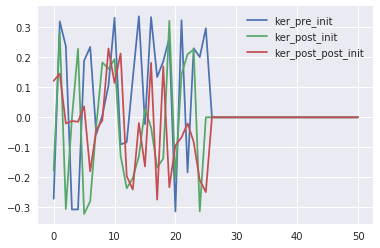

In [95]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
w_post_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post_post)
fc_w = toy_net2_trainer.evaluate(ops=toy_data_net2.fc_w)
plt.plot(w_pre,  label='ker_pre_init')
plt.plot(w_post,  label='ker_post_init')
plt.plot(w_post_post, label='ker_post_post_init')
plt.legend()
fc_w

In [98]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net2_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net2.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 1550 and Step 0002: validation cost=123.29404
Updated min validation loss!Saving model...
Global Step 1600 and Step 0052: validation cost=119.84129
Updated min validation loss!Saving model...
Global Step 1650 and Step 0102: validation cost=116.59509
Updated min validation loss!Saving model...
Global Step 1700 and Step 0152: validation cost=113.47852
Updated min validation loss!Saving model...
Global Step 1750 and Step 0202: validation cost=110.49032
Updated min validation loss!Saving model...
Global Step 1800 and Step 0252: validation cost=107.42006
Updated min validation loss!Saving model...
Global Step 1850 and Step 0302: validation cost=104.73919
Updated min validation loss!Saving model...
Global Step 1900 and Step 0352: validation cost=101.78620
Updated min validation loss!Saving model...
Global Step 1950 and Step 0402: validation cost=99.16415
Updated min validation loss!Saving model...
Global Step 2000 and Step 0452: validation cost=96.53608
Updated min validation los

KeyboardInterrupt: 

array([-0.47786525, -0.04673764,  0.77144504], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


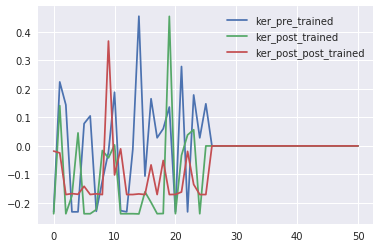

In [97]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
w_post_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post_post)
fc_w = toy_net2_trainer.evaluate(ops=toy_data_net2.fc_w)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()
fc_w

In [62]:
kernel_scale

array([ 0.0061    ,  0.0016    ,  1.09836066])